## Model generation for weather prediction dataset
In this notebook we create a neural network for weather prediction using [this](https://zenodo.org/record/7053722) dataset.  
The model will be used to explore timeseries-based explainable AI methods.  

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [2]:
fname = "weather_prediction_dataset_light.csv"
if os.path.isfile(fname):
    data = pd.read_csv(fname)
else:
    data = pd.read_csv(f"https://zenodo.org/record/5071376/files/{fname}?download=1")
data.describe()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,SONNBLICK_temp_mean,SONNBLICK_temp_min,SONNBLICK_temp_max,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
count,3.654000e+03,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,...,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000
mean,2.004568e+07,6.520799,5.418446,0.745107,1.017876,1.330380,0.234849,4.661193,11.022797,6.989135,...,-4.626327,-6.884319,-2.352244,0.781872,1.016639,1.369787,0.186100,12.205802,7.860536,16.551779
std,2.874287e+04,3.450083,2.325497,0.107788,0.007962,0.935348,0.536267,4.330112,7.414754,6.653356,...,6.987080,7.120333,6.972886,0.115572,0.018885,0.926472,0.422151,6.467155,5.692256,7.714924
min,2.000010e+07,1.000000,0.000000,0.380000,0.985600,0.050000,0.000000,0.000000,-9.300000,-16.000000,...,-26.600000,-30.300000,-24.700000,0.330000,0.000300,0.050000,0.000000,-6.200000,-13.000000,-3.100000
25%,2.002070e+07,4.000000,4.000000,0.670000,1.013300,0.530000,0.000000,0.500000,5.300000,2.000000,...,-9.400000,-11.800000,-7.100000,0.700000,1.012100,0.550000,0.000000,7.600000,3.700000,10.800000
50%,2.004567e+07,7.000000,6.000000,0.760000,1.017700,1.110000,0.000000,3.600000,11.400000,7.300000,...,-4.400000,-6.400000,-2.200000,0.800000,1.017300,1.235000,0.000000,12.300000,8.300000,16.600000
75%,2.007070e+07,10.000000,7.000000,0.830000,1.022700,2.060000,0.210000,8.000000,16.900000,12.400000,...,0.700000,-1.100000,2.700000,0.870000,1.022200,2.090000,0.160000,17.200000,12.300000,22.400000
max,2.010010e+07,12.000000,8.000000,0.980000,1.040800,3.550000,7.570000,15.300000,29.000000,20.800000,...,13.800000,8.700000,14.300000,1.000000,1.041400,3.560000,6.200000,31.200000,22.600000,39.800000


## Defining the classification task
For simplicity we take data from a single location (DE_BILT). The timeseries are split per month, and we predict whether the each timeseries belongs to winter/summer (reduce to 2 seasons for simplicity - 4 seasons or even 12 months would be more complicated for XAI).

In [3]:
columns = [col for col in data.columns if col.startswith('DE_BILT')]

data_debilt = data[columns]

In [4]:
# find where the month changes
idx = np.where(np.diff(data['MONTH']) != 0)[0]
# idx contains the index of the last day of each month, except for the last month.
# of the last month only a single day is recorded, so we discard it.

nmonth = len(idx)
# add start of first month
idx = np.insert(idx, 0, 0)
ncol = len(columns)
nday = 28

# create single object containing each timeseries
# for simplicity we truncate each timeseries to the same length, i.e. 28 days
data_ts = np.zeros((nmonth, nday, ncol))
for m in range(nmonth):
    data_ts[m] = data_debilt[idx[m]:idx[m+1]][:28]
    
print(data_ts.shape)

(120, 28, 9)


In [5]:
# the labels are the month of each timeseries
months = (np.arange(nmonth) + data['MONTH'][0]) % 12

# create one-hot encoded target. 0 = winter (oct-mar), 1 = summer (apr-sep)
target = pd.get_dummies((3 < months) & (months < 10)).to_numpy()
classes = ['winter', 'summer']

## Train - validation - test split

In [6]:
data_trainval, data_test, target_trainval, target_test = train_test_split(data_ts, target, stratify=target, random_state=0, test_size=.12)
data_train, data_val, target_train, target_val = train_test_split(data_trainval, target_trainval, stratify=target_trainval, random_state=0, test_size=.12)
print(data_train.shape, data_val.shape, data_test.shape)

(92, 28, 9) (13, 28, 9) (15, 28, 9)


## Define the model

In [7]:
def create_model():
    inputs = keras.Input(data_train.shape[1:])
    x = keras.layers.Conv1D(8, 3, padding="causal")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.Conv1D(4, 3, padding="causal")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.GlobalMaxPool1D()(x)

    outputs = keras.layers.Dense(2, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [8]:
batch_size = 8
epochs = 64
learning_rate = 1e-3

model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss="binary_crossentropy", metrics=["accuracy"])

2022-11-17 11:37:38.095817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
hist = model.fit(data_train, target_train, validation_data=(data_val, target_val), batch_size=batch_size, epochs=epochs)

Epoch 1/64
12/12 [==============================] - 1s 23ms/step - loss: 1.1850 - accuracy: 0.5000 - val_loss: 1.6223 - val_accuracy: 0.4615
Epoch 2/64
12/12 [==============================] - 0s 5ms/step - loss: 0.9274 - accuracy: 0.5000 - val_loss: 1.3782 - val_accuracy: 0.5385
Epoch 3/64
12/12 [==============================] - 0s 5ms/step - loss: 0.7869 - accuracy: 0.5217 - val_loss: 1.2001 - val_accuracy: 0.5385
Epoch 4/64
12/12 [==============================] - 0s 4ms/step - loss: 0.7460 - accuracy: 0.5652 - val_loss: 1.0363 - val_accuracy: 0.6923
Epoch 5/64
12/12 [==============================] - 0s 5ms/step - loss: 0.7009 - accuracy: 0.5870 - val_loss: 0.8965 - val_accuracy: 0.8462
Epoch 6/64
12/12 [==============================] - 0s 5ms/step - loss: 0.6554 - accuracy: 0.6304 - val_loss: 0.7966 - val_accuracy: 0.9231
Epoch 7/64
12/12 [==============================] - 0s 5ms/step - loss: 0.6444 - accuracy: 0.6522 - val_loss: 0.7176 - val_accuracy: 0.9231
Epoch 8/64
12/12 [=

Text(0, 0.5, 'Accuracy')

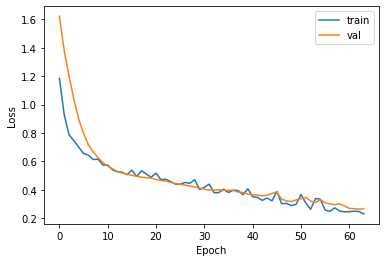

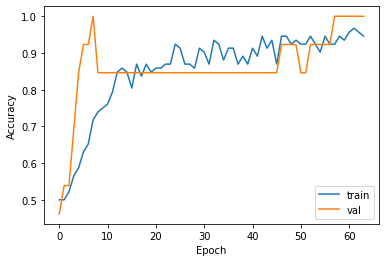

In [10]:
plt.plot(hist.epoch, hist.history['loss'], label='train')
plt.plot(hist.epoch, hist.history['val_loss'], label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure()
plt.plot(hist.epoch, hist.history['accuracy'], label='train')
plt.plot(hist.epoch, hist.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

## Run model on test set

In [11]:
pred_test = model.predict(data_test)

1/1 [==============================] - 0s 123ms/step


In [12]:
acc = (target_test.argmax(axis=1) == pred_test.argmax(axis=1)).sum() / len(target_test)
print(f'Accuracy on test set: {100*acc:.0f}%')

Accuracy on test set: 100%


## Save model

In [13]:
model_dir = 'weather_prediction_model'
model.save(model_dir)

INFO:tensorflow:Assets written to: weather_prediction_model/assets


INFO:tensorflow:Assets written to: weather_prediction_model/assets


In [14]:
output_file = 'weather_prediction_model.onnx'
!python -m tf2onnx.convert --keras {model_dir} --output {output_file}

/Users/loostrum/pyenv/versions/3.9.1/lib/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
/Users/loostrum/pyenv/versions/dianna/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:437: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-11-17 11:37:50,905 - WARNING - From /Users/loostrum/pyenv/versions/dianna/lib/python3.9/site-packages/tf2onnx/tf_loader.py:706: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future v